In [ ]:
import matplotlib.pyplot as plt
import cv2

In [204]:
import numpy as np


class Conv2D:
    """Implements 2d convolution layer"""

    def __init__(
        self,
        n_in: int,
        n_out: int,
        kernel_size: tuple[int, int],
        strides: tuple[int, int] = (1, 1),
        padding: str = "valid",
        use_bias: bool = True,
        dilations: tuple[int, int] = (1, 1),
    ):
        """Initialized Conv2D layer.
        The weights are initialized using uniformly distributed values in range [-1, 1]. Bias vector is not initialized if `use_bias` is False.
        Weights tensor has the shape (`kernel_size[0]`, `kernel_size[1]`, `n_in`, `n_out`), bias vector has the shape (`n_out`, ).

        Arguments:
            n_in: Positive integer, dimensionality of input space.
            n_out: Positive integer, dimensionality of output space.
            kernel_size: Pair of positive integers, convolution kernel dimensions.
            strides: Pair of positive integers, convolution strides along each dimension.
            padding: Either 'valid' or 'same', padding to be used by the layer, see explanation below.
            use_bias: Whether the layer uses a bias vector.
            dilations: Pair of positive integers, convolution kernel dilations along each dimension.

        Padding:
            'valid': no padding is applied.
            'same': padding along every dimension is computed as follows
                if dimension_size % stride == 0:
                    total_pad = max((kernel_size - 1) * dilation + 1 - stride)
                else:
                    total_pad = max((kernel_size - 1) * dilation + 1 - dimension_size % stride)
                pad_before = total_pad // 2
                pad_after = total_pad - pad_before"""
        self.n_in = n_in
        self.n_out = n_out
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
        self.dilations = dilations

        self._weights = np.random.uniform(
            -1, 1, (kernel_size[0], kernel_size[1], n_in, n_out)
        )
        if use_bias:
            self._bias = np.random.uniform(-1, 1, (n_out))

    @property
    def weights(self) -> tuple[np.ndarray, np.ndarray] | tuple[np.ndarray]:
        """Returns weights used by the layer. Weight tensor and bias vector if use_bias is True"""
        if self.use_bias:
            return (self._weights, self._bias)
        return (self._weights,)

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Performs the layer forward pass.

        Arguments:
            x: Input array of shape (`batch_size`, `height`, `width`, `n_in`).

        Returns:
            An array of shape (`batch_size`, `new_height`, `new_width`, `n_out`)."""
        if x.strides[-1] < 1:
            raise ValueError("Stride < 1")

        x = self.prepare_x(x)
        convolved = np.einsum("...ijk,ijkz", x, self._weights, dtype=x.dtype)

        if self.use_bias:
            convolved += self._bias[None, None, None]
        return convolved

    def prepare_x(self, x):
        if self.padding == "same":
            paddings = []
            for dimension_size, stride, kernel_size, dilation in zip(
                x.shape[1:3], self.strides, self.kernel_size, self.dilations
            ):
                if dimension_size % stride == 0:
                    total_pad = (kernel_size - 1) * dilation + 1 - stride
                else:
                    total_pad = (
                        (kernel_size - 1) * dilation + 1 - dimension_size % stride
                    )
                pad_before = total_pad // 2
                pad_after = total_pad - pad_before
                paddings.append([pad_before, pad_after])

            # TODO: pad mode?
            x = np.pad(x, ((0, 0), *paddings, (0, 0)))

        batch_step, row_step, chanel_step, dtype_size = x.strides
        batch, height, width, chanels = x.shape

        x = np.lib.stride_tricks.as_strided(
            x,
            shape=(
                batch,
                height - self.kernel_size[0] + 1,
                width - self.kernel_size[1] + 1,
                self.kernel_size[0],
                self.kernel_size[1],
                self.n_in,
            ),
            strides=(
                batch_step,  # dist between batches
                row_step,  # dist between rows
                chanel_step,  # dist between chanels,
                row_step,
                chanel_step,
                dtype_size,
            ),
            # strides=(
            #     batch_step,  # dist between batches
            #     row_step * self.strides[0],  # dist between rows
            #     chanel_step * self.strides[1],  # dist between chanels,
            #     row_step * self.dilations[0],
            #     chanel_step  * self.dilations[1],
            #     dtype_size,
            # )
        )
        return x

    def grad(
        self, x: np.ndarray, gradOutput: np.ndarray
    ) -> tuple[np.ndarray, tuple[np.ndarray, np.ndarray] | tuple[np.ndarray]]:
        """Computes layer gradients

        Arguments:
            gradOutput: Gradient of loss function with respect to the layer output, an array of shape (`batch_size`, `new_height`, `new_width`, `n_out`).

        Returns:
            A tuple object:
                Gradient of loss function with respect to the layer input, an array of shape (`batch_size`, `height`, `width`, `n_in`)
                Gradient of loss function with respect to the layer's weights:
                    An array of shape (`kernel_size[0]`, `kernel_size[1]`, `n_in`, `n_out`).
                    Optional array of shape (`n_out`, )."""

        d_k = np.einsum(
            "bij...k, bijz", self.prepare_x(x), gradOutput, dtype=x.dtype
        )
        if self.use_bias:
            d_b = np.einsum("bijk -> k", gradOutput)
            return (d_k, d_b)
        return (d_k,)

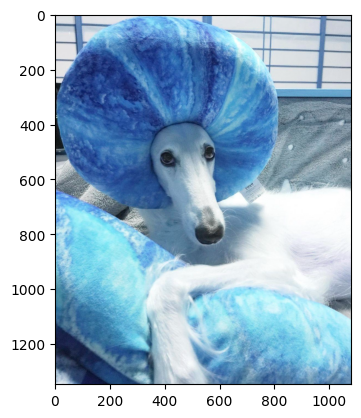

In [205]:
image = cv2.imread("example.jpg").astype(float)/255
plt.imshow(image)
plt.show()

(2, 1347, 1080, 1)


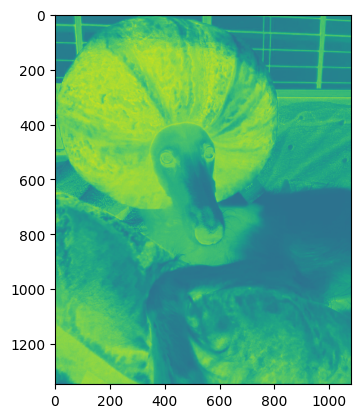

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


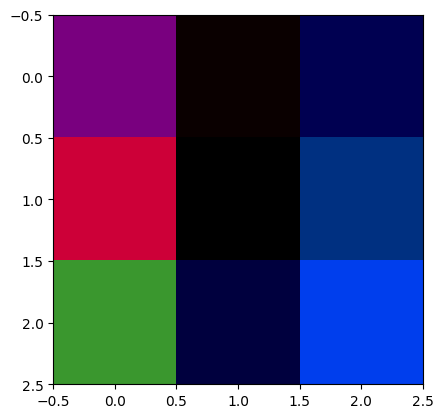

In [230]:
layer = Conv2D(3, 1, (3, 3), padding="same")
# w = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])[..., None].repeat(3, -1)[..., None]
# layer._weights = w

processed = layer(image[None].repeat(2, 0))
print(processed.shape)
plt.imshow(processed[0])
plt.show()
plt.imshow(layer._weights[..., -1])
plt.show()


In [203]:
print(image[None].repeat(2, 0).shape, processed.shape)
list(map(lambda x: x.shape, layer.grad(image[None].repeat(2, 0), processed)))

(2, 1347, 1080, 3) (2, 1347, 1080, 1)


[(3, 3, 3, 1), (1,)]

In [174]:
image[None].repeat(2, 0).shape

(2, 1347, 1080, 3)